In [1]:
import pymc as pm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Impostazione del seme per la riproducibilità
np.random.seed(84735)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
brain_data = pd.read_csv("../data/brain_data.csv")
brain_data.head()

,ID,GENDER,FSIQ,VIQ,PIQ,MRI,IQDI
0,2,Male,140,150,124,1001121,Higher IQ
1,3,Male,139,123,150,1038437,Higher IQ
2,4,Male,133,129,128,965353,Higher IQ
3,9,Male,89,93,84,904858,Lower IQ
4,10,Male,133,114,147,955466,Higher IQ


In [4]:
# Filtraggio dei dati per i maschi
males = brain_data[brain_data['GENDER'] == 'Male']
males.shape

(20, 7)

In [5]:
# Standardizzazione di MRI e FSIQ
males['fsiq'] = (males['FSIQ'] - males['FSIQ'].mean()) / males['FSIQ'].std()
males['mri'] = (males['MRI'] - males['MRI'].mean()) / males['MRI'].std()

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_33970/2956472145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males['fsiq'] = (males['FSIQ'] - males['FSIQ'].mean()) / males['FSIQ'].std()
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_33970/2956472145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males['mri'] = (males['MRI'] - males['MRI'].mean()) / males['MRI'].std()


<Axes: xlabel='mri', ylabel='fsiq'>

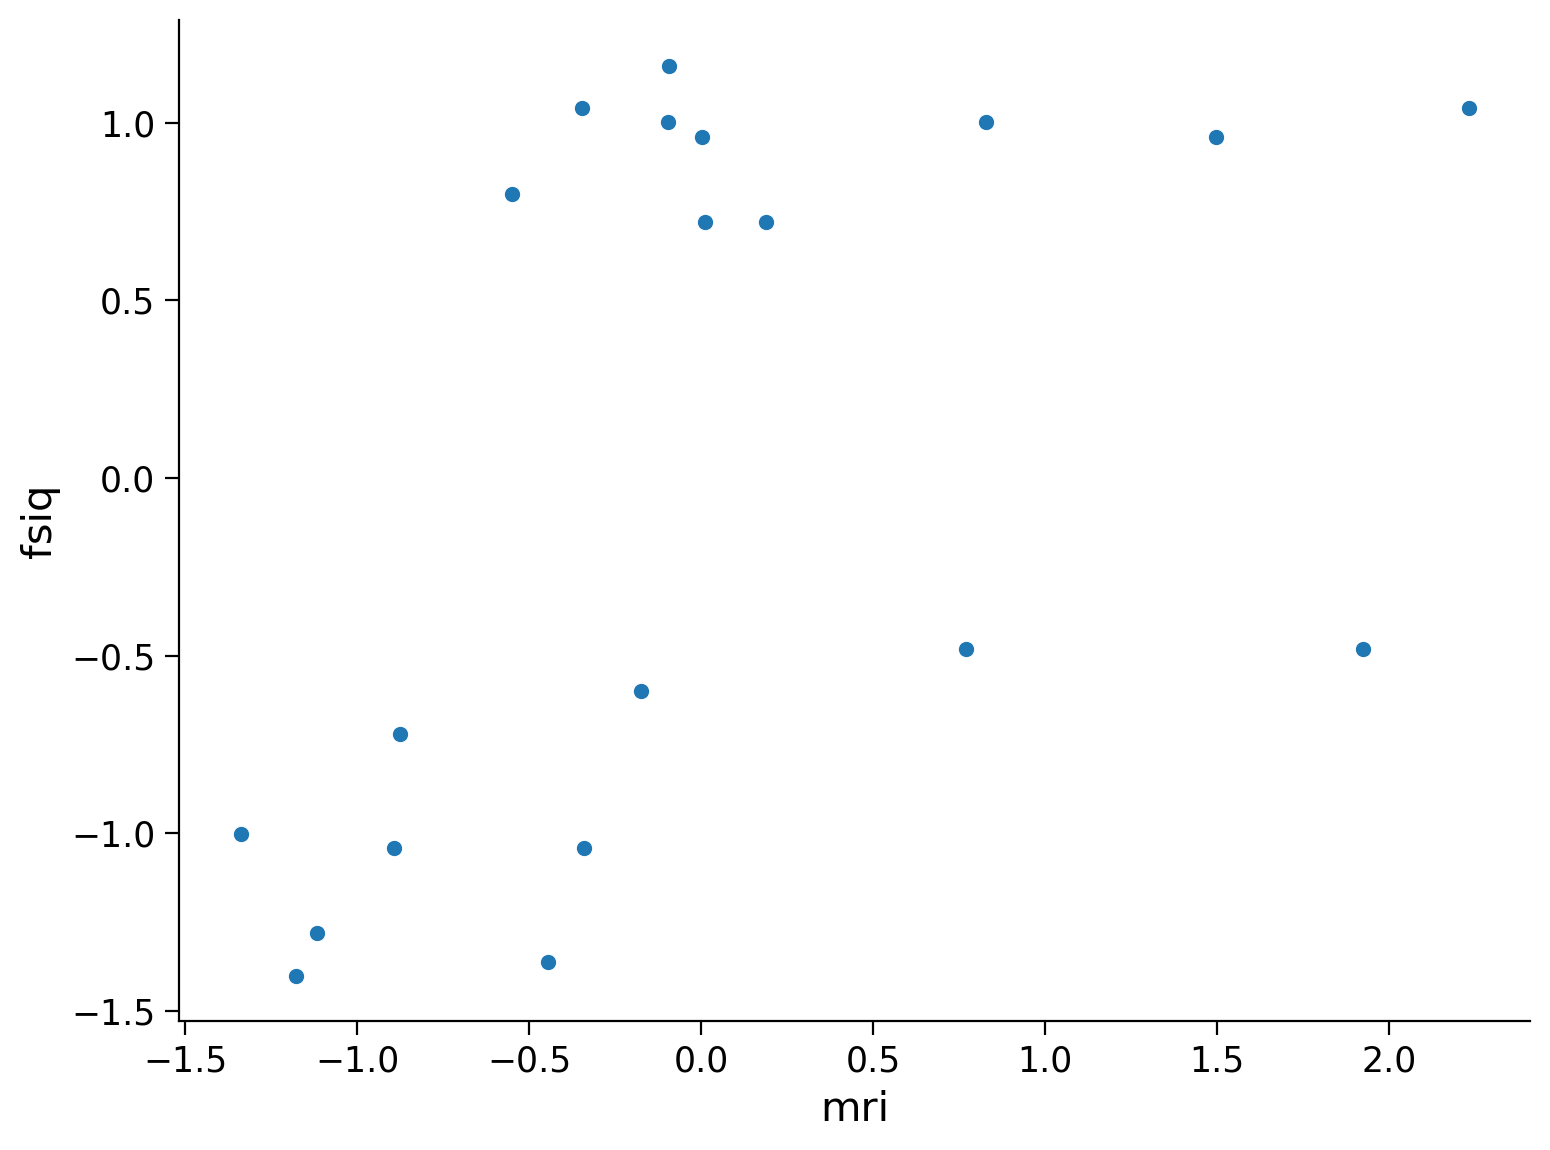

In [6]:
# Diagramma a dispersione
sns.scatterplot(data=males, x='mri', y='fsiq')

In [7]:
# Dati per il modello
data = {
    'N': len(males['fsiq']),
    'x': males['mri'].values,
    'y': males['fsiq'].values
}

df = pd.DataFrame(data)
df.head()

,N,x,y
0,20,0.827481,1.000548
1,20,1.494895,0.960526
2,20,0.187754,0.720394
3,20,-0.894226,-1.040570
4,20,0.010921,0.720394


In [8]:
# Definizione del modello
with pm.Model() as model:
    alpha = pm.Normal("alpha", 0, 2.5)
    beta = pm.Normal("beta", 0, 2.5)
    sigma = pm.HalfNormal("sigma", 10)
    mu = alpha + beta * data["x"]
    y_obs = pm.Normal("y_obs", mu, sigma, observed=data["y"])

In [9]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


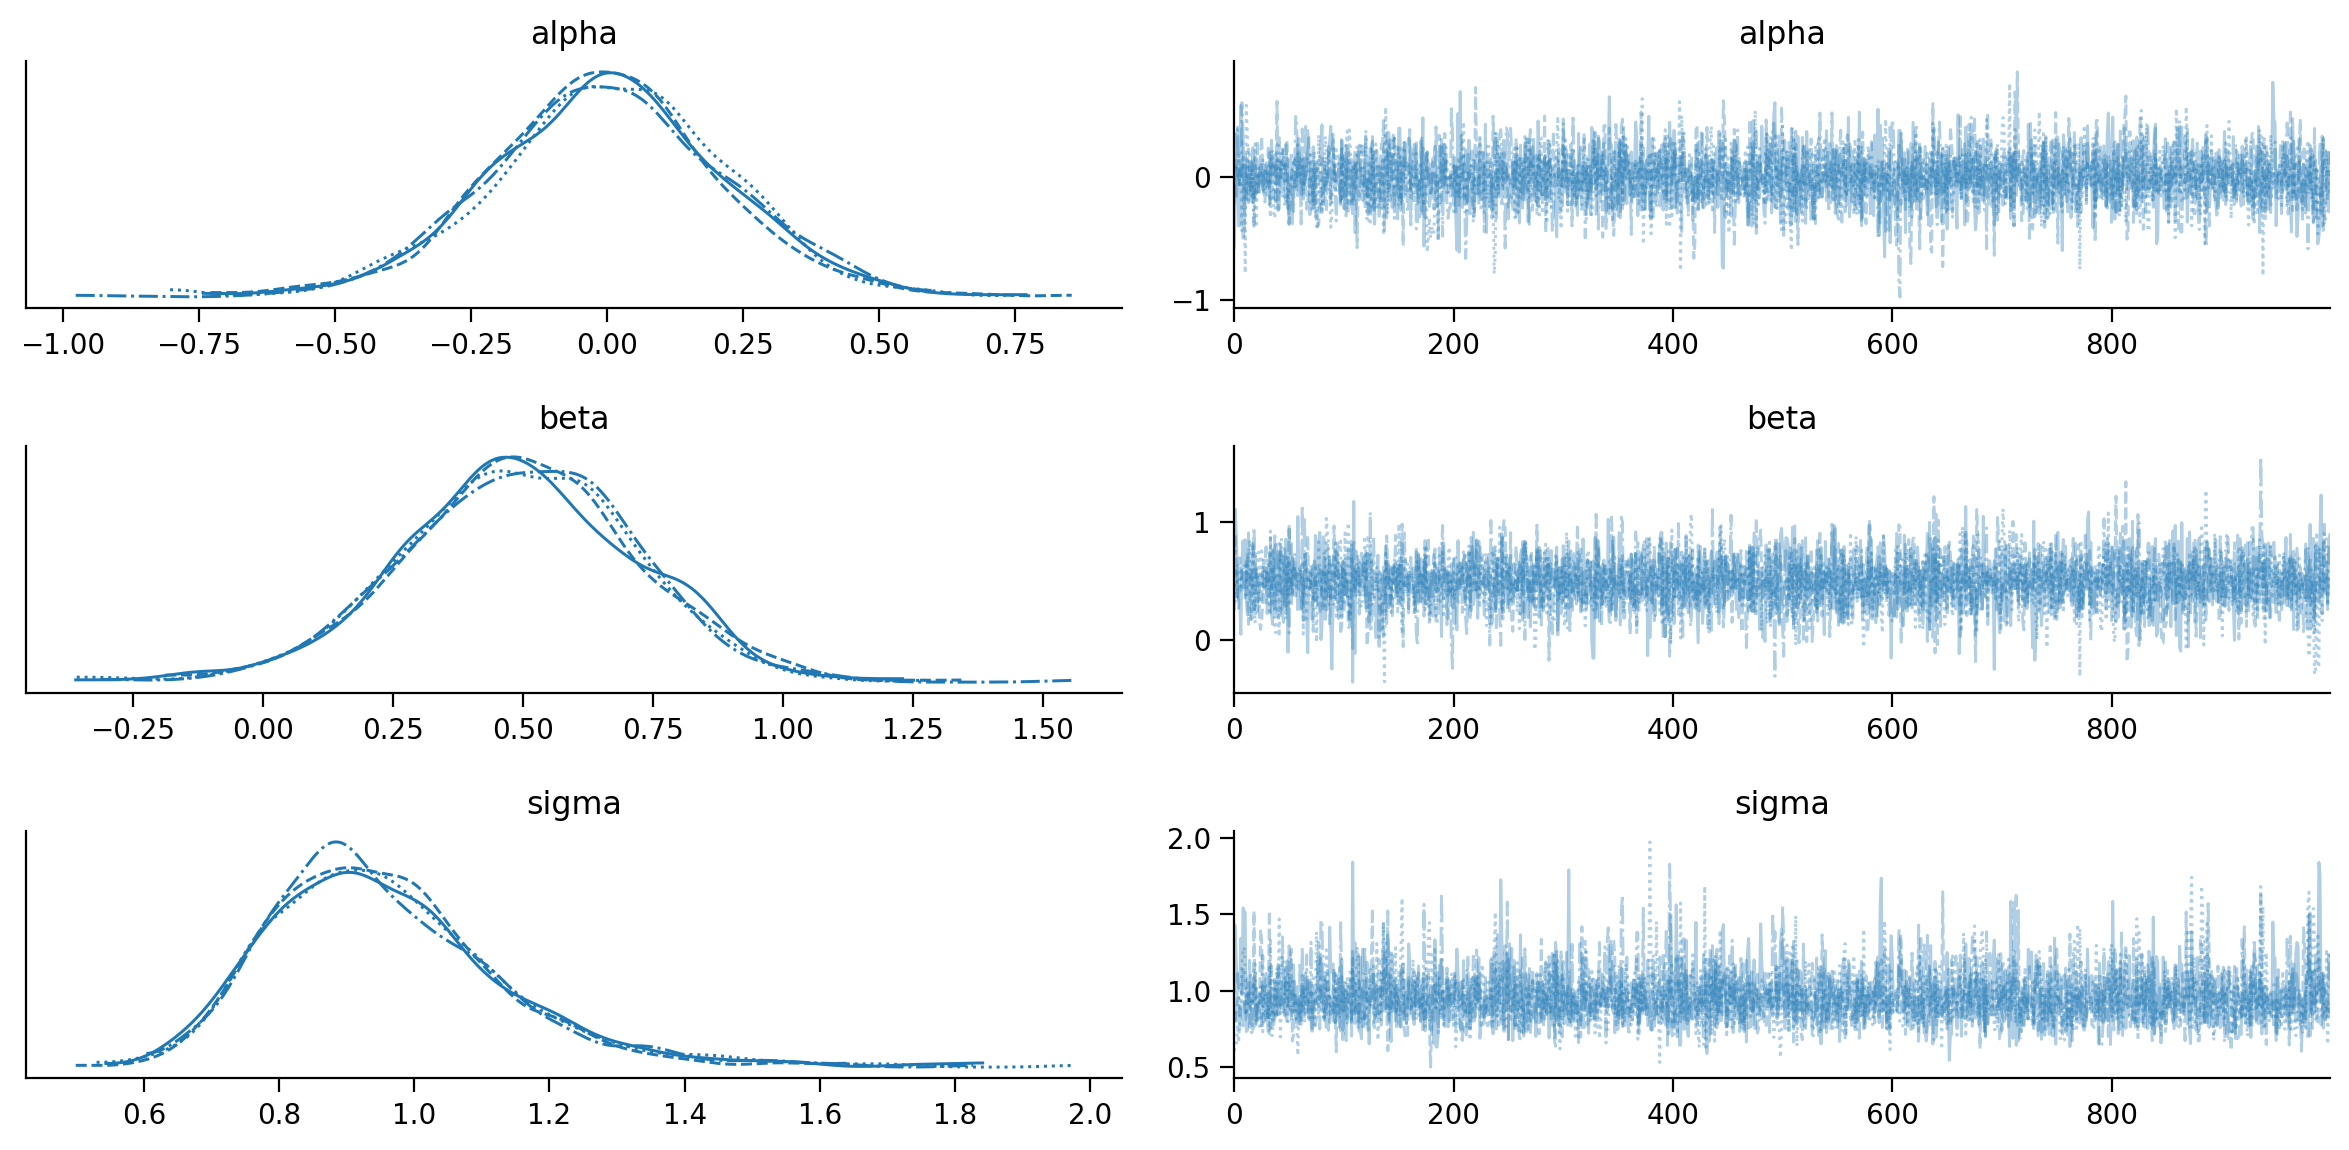

In [10]:
# Diagnostica
az.plot_trace(idata);

In [11]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.21,-0.40,0.41,0.0,0.0,4767.07,2894.58,1.0
beta,0.49,0.22,0.09,0.91,0.0,0.0,3861.09,2541.83,1.0
sigma,0.96,0.17,0.67,1.28,0.0,0.0,3251.77,2650.32,1.0


In [12]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset> Size: 96B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    alpha    (hdi) float64 16B -0.4249 0.4154
    beta     (hdi) float64 16B 0.05738 0.9191
    sigma    (hdi) float64 16B 0.639 1.29

In [13]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
# Probabilità che beta sia maggiore di 0
prob_beta_positive = (idata.posterior["beta"] > 0).mean()
print("Probabilità che beta sia maggiore di 0:", prob_beta_positive)

Probabilità che beta sia maggiore di 0: <xarray.DataArray 'beta' ()> Size: 8B
array(0.9835)


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

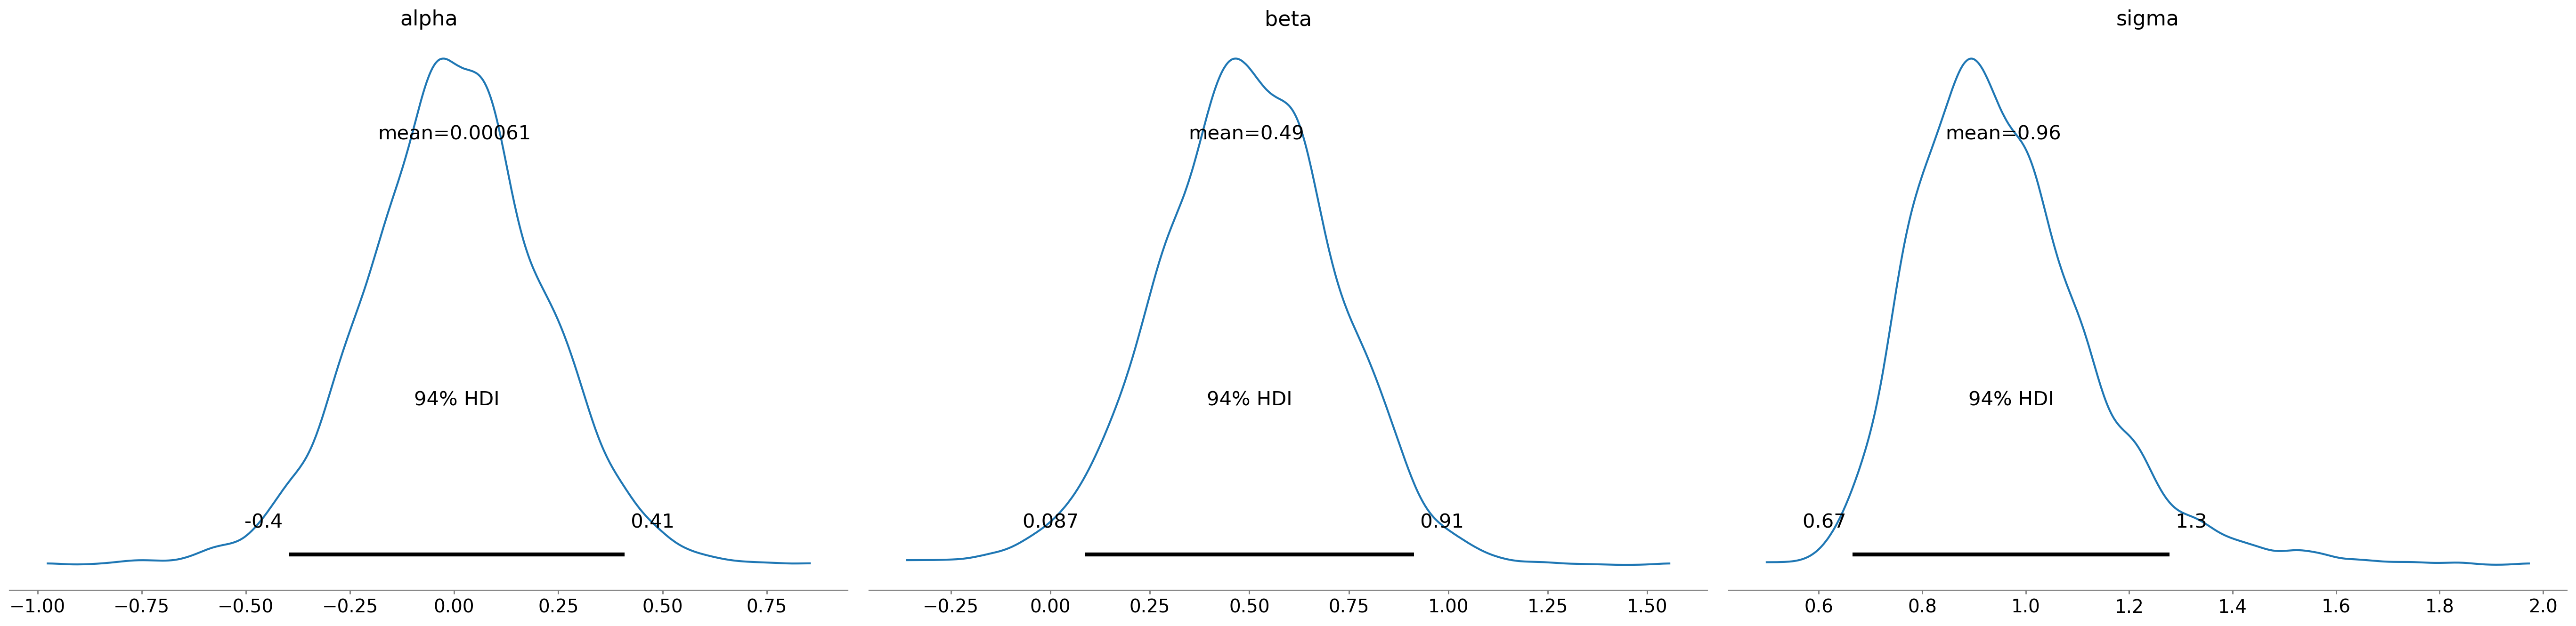

In [15]:
# Grafico della distribuzione a posteriori dei parametri
az.plot_posterior(idata, round_to=2)